In [1]:
from opthh.model import Model
from pylab import plt

# Class for our new model
class Custom(Model):
    
    # Our model has membrane conductance as its only parameter
    default_params = {'C_m' : 1., 'g_L' : 0.1, 'E_L' : 50.}
    # Initial value for the voltage
    _init_state = [0.]
    
    def __init__(self, init_p, tensors=False, dt=0.1):
        Model.__init__(self, init_p=init_p, tensors=False, dt=0.1)
        
    def _i_L(self, V):
        return self._param['g_L'] * (self._param['E_L'] - V)
        
    @staticmethod
    def step_model(X, i_inj, self):
        # Update the voltage
        V = X[0]
        V += self.dt * (i_inj + self._i_L(V)) / self._param['C_m']
        return [V]
        
    @staticmethod
    def get_random():
        # Useful later
        pass
    
    def plot_results(self, ts, i_inj_values, V, ca_true=None, suffix="", show=True, save=False):
        
        il = self._i_L(V)
        
        plt.figure()

        plt.subplot(3, 1, 1)
        plt.plot(ts, V, 'k')
        plt.title('Leaky Integrator Neuron')
        plt.ylabel('V (mV)')
        
        plt.subplot(5, 1, 3)
        plt.plot(ts, il, 'g', label='$I_{L}$')
        plt.ylabel('Current')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(ts, i_inj_values, 'b')
        plt.xlabel('t (ms)')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        # plt.ylim(-1, 40)

        if save:
            plt.savefig('{}results_{}.png'.format(DIR, suffix), dpi=300)
        if show:
            plt.show()
        plt.close()
        
        

In [2]:
from opthh import config
config.NEURON_MODEL = Custom

from opthh.neuronsimul import NeuronSimul
import scipy as sp

0.09044766426086426


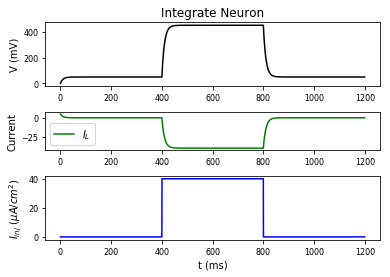

[array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.1997e+03, 1.1998e+03,
        1.1999e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.5    ,  0.995  ,  1.48505, ..., 50.     , 50.     , 50.     ]),
 array([ 0.5    ,  0.995  ,  1.48505, ..., 50.     , 50.     , 50.     ])]

In [3]:
t = sp.arange(0., 1200., 0.1)
i = 40. * ((t > 400) & (t < 800))
simul = NeuronSimul(t=t, i_inj=i)
simul.simul(show=True, save=False)